In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

# Neuroblastoma CWAS RNA

Alright, here's the other arm of this analysis that we'd like to pursue. I want to examine the expression of genes potentially affected by SVs in these categories from Riaz's CWAS analysis.

We have expression data for a subset of the neuroblastoma cases. The idea of this analysis is to answer the following question:

`Are the significant categories reflected in increases of expression in their target genes?`

Doing this is a bit tricky, and we'll need to derive an appropriate framework. One key difficulty is that we have _no idea_ of the underlying purity or characteristics of these RNA samples. As a result, directly comparing expression values is difficult. But we'll try our best.

# Load our data

Since we'll be doing a category analysis, we have to load basically all our data.

## Read in SVs

In [2]:
# define SVs and dosages
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

In [3]:
# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv("ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt")
gene_ref = gene_ref[~gene_ref['value'].str.startswith('ENSG00')]
gene_ref = gene_ref['value'].tolist()

Load metadata and SVs

In [4]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

Now we load the SVs. We combine discovery and validation, although I'm pretty sure our TPM subset is only one of those.

In [5]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
)

###############
### Dosages ###
###############
dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [6]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [7]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [8]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [9]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

## Read in TPMs

Load our TPMs. We'll briefly take a look at the manifest file first.

In [10]:
manifest = pd.read_csv('data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/GMKF_neuroblastoma_transcriptomic_data_manifest_rsem_gene_files_2_22_22.txt', sep='\t')
manifest = manifest.dropna(subset = manifest.columns, how = 'all')
manifest.head(2)

,id,name,file_name_simplified,size,project,ethnicity,gender,race,vital_status,sample_id,sample_type,platform,age_at_diagnosis,tumor_location,aliquot_id,library_id,histology,composition,reference_genome,species,case_id,data_type,investigation,experimental_strategy
0,62140522c087b02cb6535584,4452cf2b-df37-439b-92d0-7e3853c50eee.rsem.gene...,4452cf2b-df37-439b-92d0-7e3853c50eee,2503209.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Female,Reported Unknown,Alive,BS_5W25GMQ1,Tumor,Illumina,1295.0,Reported Unknown,575765.0,GMKF-30-PATMDE03-01B-99R,"Ganglioneuroblastoma, intermixed",Solid Tissue,GRCh38,Homo sapiens,PT_4A1B95TK,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq
1,62140522c087b02cb6535578,7e31540e-112f-439a-9562-ad760bb6d5c5.rsem.gene...,7e31540e-112f-439a-9562-ad760bb6d5c5,2488632.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Male,White,Alive,BS_5Y7PNW71,Tumor,Illumina,1712.0,Reported Unknown,575872.0,GMKF-30-PAVKZC03-01A-01R,"Ganglioneuroblastoma, nodular",Solid Tissue,GRCh38,Homo sapiens,PT_GSWXPFPQ,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq


In [11]:
manifest.shape

(209, 24)

Not very useful at all, but it does give us a way to map file names to sample names.

In [12]:
file_to_sample = dict(zip(manifest['name'], manifest['case_id']))

In [13]:
merged_tpms = []
merged_counts = []
for file in glob.glob('data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/*.rsem.genes.tsv'):
    file_name = file.split('/')[-1][:-3] + 'results.gz'
    
    sample = file_to_sample[file_name]

    data = pd.read_csv(file, sep = '\t')
    data['sample'] = sample
    merged_tpms.append(data[['sample', 'gene_id', 'TPM']])
    merged_counts.append(data[['sample', 'gene_id', 'expected_count']])
    
merged_tpms = pd.concat(merged_tpms)
merged_tpms = merged_tpms.pivot(index = "gene_id", columns = 'sample', values = 'TPM').reset_index()

merged_counts = pd.concat(merged_counts)
merged_counts = merged_counts.pivot(index = "gene_id", columns = 'sample', values = 'expected_count').reset_index()

In [14]:
for d in [merged_tpms, merged_counts]:
    d.insert(1, 'ENSEMBL_ID', d['gene_id'].apply(lambda x: x.split('.')[0]))
    d.insert(2, 'gene_symbol', d['gene_id'].apply(lambda x: x.split('_')[-1]))

In [15]:
merged_tpms.to_csv('data/merged_neuroblastoma_tpms.tsv', sep = '\t', index = False)
merged_counts.to_csv('data/merged_neuroblastoma_counts.tsv', sep = '\t', index = False)

In [16]:
merged_tpms.head(2)

sample,gene_id,ENSEMBL_ID,gene_symbol,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
0,ENSG00000000003.14_TSPAN6,ENSG00000000003,TSPAN6,3.61,7.62,4.30,2.15,5.05,9.24,4.71,5.88,1.38,4.27,2.02,3.36,3.17,7.48,5.85,10.18,0.0,3.53,6.71,3.07,6.36,3.53,3.48,3.11,2.27,5.29,5.13,8.56,8.71,6.89,5.84,6.03,4.88,3.21,4.91,5.69,5.14,3.42,5.52,3.64,9.19,4.50,4.14,8.18,4.75,6.09,2.19,1.03,5.56,7.46,4.38,16.69,5.32,2.22,3.48,12.82,3.93,5.42,5.33,15.09,6.02,7.87,6.65,8.35,7.13,6.33,3.32,16.37,5.19,7.46,4.49,16.05,7.10,11.59,3.77,7.35,15.50,3.45,2.43,2.27,1.93,2.85,8.17,3.3,11.01,6.02,3.75,9.38,12.32,6.57,4.12,1.08,4.35,5.62,6.61,5.42,5.80,8.86,6.82,2.15,8.82,4.54,2.85,5.47,6.03,5.99,4.87,3.6,3.61,13.90,4.05,3.34,5.47,10.79,4.32,4.17,6.61,4.58,4.77,28.44,3.00,5.50,3.37,2.47,5.95,5.51,9.22,2.67,6.49,5.25,6.79,9.47,3.72,7.45,5.42,2.37,8.00,4.01,7.13,2.59,4.60,7.1,4.46,3.52,4.06,7.82,11.20,4.77,1.33,5.72,6.19,8.68,2.80,1.63,8.07,8.86,2.94,6.56,3.98,4.65,3.64,5.25,2.78,3.71,2.12,11.43,5.96,16.48,3.31,5.27,6.14,4.64,0.0,19.99,4.49,4.63,4.94,4.78,2.71,7.94,7.36,2.39,3.04,2.21,3.59,4.35,7.1,12.48,2.59,5.76,4.59,9.73,4.56,14.11,3.07,12.56,13.63,5.41,2.94,3.57,2.71,3.73,5.58,8.16,4.73,13.37,3.1,10.42,9.68
1,ENSG00000000005.5_TNMD,ENSG00000000005,TNMD,0.03,0.00,0.05,0.00,0.11,0.00,0.07,0.02,0.09,0.12,0.02,0.02,0.00,0.00,0.03,0.03,0.0,0.00,0.00,0.02,0.07,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.16,0.00,0.15,0.00,0.06,0.00,0.00,0.

For the most part, we don't care about non-genes (e.g. lncRNA's, etc). There are definitely instances, however, where we might care about them.

Let's just create a separate dataset for coding analyses.

In [17]:
# Connect to the BioMart server and use the Ensembl dataset
server = BiomartServer("http://www.ensembl.org/biomart")
ensembl = server.datasets['hsapiens_gene_ensembl']

# Query the database to get the Ensembl gene IDs and HGNC symbols for genes with RefSeq mRNA annotations
response = ensembl.search({
    'filters': {'with_refseq_mrna': True},
    'attributes': ['ensembl_gene_id', 'hgnc_symbol']
})

# # Create a list of tuples from the response
data = [line.decode('utf-8').split('\t') for line in response.iter_lines()]

# Convert the list of tuples into a pandas DataFrame
genes_df = pd.DataFrame(data, columns = ['ensembl_gene_id', 'hgnc_symbol'])

# Display the DataFrame - the first few rows don't have gene names
genes_df.head(6)

,ensembl_gene_id,hgnc_symbol
0,ENSG00000271254,
1,ENSG00000277630,
2,ENSG00000274175,
3,ENSG00000275869,
4,ENSG00000276256,
5,ENSG00000281934,PRAMEF11


In [18]:
merged_tpms_protein_coding = merged_tpms.merge(genes_df, left_on = ['ENSEMBL_ID'], right_on = 'ensembl_gene_id', how = 'inner')
merged_tpms_protein_coding = merged_tpms_protein_coding.drop(columns = ['ensembl_gene_id', 'hgnc_symbol'])
merged_tpms_protein_coding.iloc[:, 3:] = np.divide(merged_tpms_protein_coding.iloc[:, 3:], merged_tpms_protein_coding.iloc[:, 3:].sum(axis = 0)) * 1e6

In [19]:
merged_tpms_protein_coding.to_csv('data/merged_neuroblastoma_coding_tpms.tsv', sep = '\t', index = False)

# Examine our TPMs

Our first step, naturally, is to examine our TPMs. There are a few questions we need to answer about this dataset.

First, how many samples are present?

## Sample characteristics

In [20]:
samples = list(merged_tpms.columns[3:])
len(samples)

209

And how many of these samples do we actually have SVs for?

In [21]:
len(set(metadata['entity:sample_id']) & set(samples))

158

Only 158... I assume that these samples were dropped for QC reasons.

In [22]:
metadata[metadata['entity:sample_id'].isin(samples)].groupby(['neuroblastoma_case']).size()

neuroblastoma_case
False    69
True     89
dtype: int64

So a large number of these samples were actually dropped from the case control analysis, presumably for sample specific reasons. Unfortunate.

In [23]:
included_samples = metadata[(metadata['entity:sample_id'].isin(samples)) &
                            (metadata['neuroblastoma_case'] == True)]['entity:sample_id'].tolist()
len(included_samples)

89

In [24]:
merged_tpms = merged_tpms[list(merged_tpms.columns[:3]) + included_samples]
merged_counts = merged_counts[list(merged_counts.columns[:3]) + included_samples]
merged_tpms_protein_coding = merged_tpms_protein_coding[list(merged_tpms_protein_coding.columns[:3]) + included_samples]

# TPM quality

It's pretty damn hard to assess the quality of RNA sequencing post-hoc, but we'll give it our best shot. We have 89 samples. I'd like to know some underlying features of this data.

The first thing we can do is just snoRNAs, which can be high in bad data.

## snoRNAs

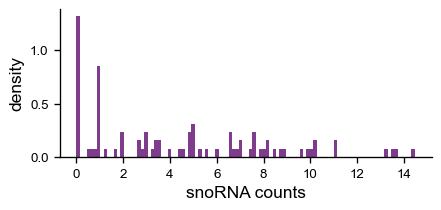

In [25]:
sno_rsem = merged_counts[merged_counts['gene_symbol'].str.contains('sno')].iloc[:, 3:]

# filter down to any sno "genes" that have nonzero reads in any samples
fig, ax = plt.subplots(1, figsize = (5, 2))
plt.hist(sno_rsem.loc[(sno_rsem != 0).any(axis = 1)].sum(axis = 0), bins = 100, density = True);
ax.set_xlabel('snoRNA counts')
ax.set_ylabel('density')
sns.despine(ax = ax)
fig.savefig('images/cwas/tpms-snorna-counts.png', bbox_inches = 'tight')

Some of those values are definitely a little higher than I'd like, but it is what it is. I don't know enough to create some filter.

## PCA plot

In [26]:
tpm_dict = {'log_1p': np.log1p(merged_tpms.iloc[:, 3:]),
            'log_1p_protein': np.log1p(merged_tpms_protein_coding.iloc[:, 3:])}

In [27]:
# normalize for PCA
pca_dict = {}
pca_models = {}
for label, matrix in tpm_dict.items():
    norm_matrix = preprocessing.StandardScaler().fit_transform(matrix.T)
    pca = decomposition.PCA(n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0)
    
    # store the model
    pca_models[label] = pca
    
    # transform the data, then store the PC results
    pca_transformed_data = pca.fit_transform(norm_matrix)
    
    pca_tpm_df = pd.DataFrame(pca_transformed_data)
    pca_tpm_df.columns = ['PC' + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
    pca_tpm_df.index = merged_tpms.columns[3:]
    
    pca_dict[label] = pca_tpm_df

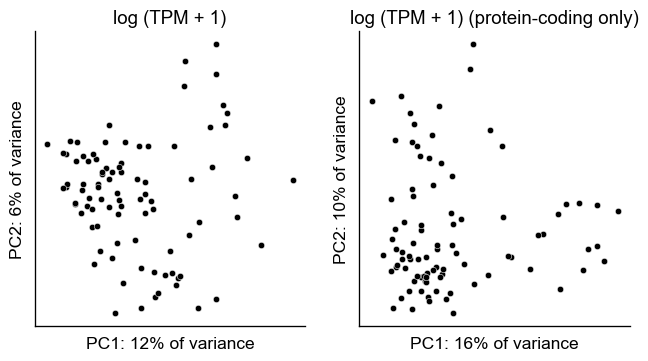

In [28]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize = (8, 4))
for i, label in enumerate(['log_1p', 'log_1p_protein']):
    
    data = pca_dict[label][['PC1', 'PC2']].copy()
    
    # plot data
    sns.scatterplot(x = 'PC1', y = 'PC2', data = data, ax = tpm_axes[i], color = 'black')
    
    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis='both', which='both', length = 0)
    
    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel('PC1: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[0]*100))
    tpm_axes[i].set_ylabel('PC2: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[1]*100))
    tpm_axes[i].set_title(['log (TPM + 1)', 'log (TPM + 1) (protein-coding only)', 'log (TPM + 1) (hvg)'][i])
    
    sns.despine(bottom = False, left = False)


Obviously, this tells us nothing up front.

## House keeping genes

Another metric we can use is the count of house-keeping genes.

In [39]:
housekeeping = ['ACTB', 'GAPDH', 'TBP', 'UBC', 'RPS18']
housekeeping_tpms = merged_tpms[merged_tpms['gene_symbol'].isin(housekeeping)].set_index('gene_symbol').iloc[:, 2:]
housekeeping_tpms_norm = stats.zscore(housekeeping_counts, axis = 1)

Let's plot these on a heatmap

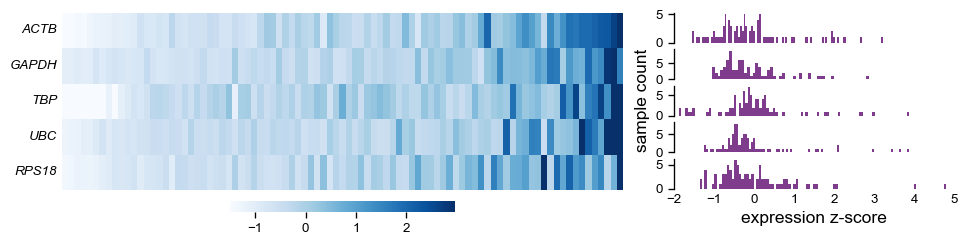

In [40]:
# define a rough order
sample_order = c.mean(axis = 0).sort_values().index

# make the figure and gridspec
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(5, 2, width_ratios = [2, 1], wspace = 0.12)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[:, 0])

sns.heatmap(housekeeping_tpms_norm.loc[:, sample_order], cmap="Blues", robust=True, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.05, 'shrink': 0.4})
heatmap_ax.set_yticklabels(housekeeping, rotation = 0, ha = 'right', fontstyle = 'italic')
heatmap_ax.tick_params(which = 'both', length = 0)
heatmap_ax.set_xticklabels([])
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

gene_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(6, 1, gs[:, 1], height_ratios = [1] * 5 + [1.3])
for i, g in enumerate(housekeeping):
    ax = fig.add_subplot(gene_gs[i])
    ax.hist(housekeeping_tpms_norm.loc[g, :], bins = 100)
    sns.despine(ax = ax, bottom = True)
    ax.set_xlim([-2, 5])
    if i != 4:
        ax.get_xaxis().set_visible(False)
        
    else:
        ax.tick_params(axis = 'x', length = 0)
        ax.set_xlabel('expression z-score')
        
    if i == 2:
        ax.set_ylabel('sample count')
        
fig.savefig('images/cwas/housekeeping-expression.png', bbox_inches = 'tight')

We can try arbitrarily removing a subset of samples if they exceed 2.5 stds of housekeeping expression in 3 housekeeping genes.

In [48]:
percentiles = np.percentile(housekeeping_tpms_norm, [95], axis = 1).reshape(-1, 1)
sample_filter = np.greater(housekeeping_tpms_norm, percentiles)
removed_samples = sample_filter.loc[:, sample_filter.sum(axis = 0) >= 3]
removed_samples

sample,PT_6WE8JADD,PT_HB9JT4G5,PT_P111JVHP
gene_symbol,,,
ACTB,True,True,True
GAPDH,True,False,True
TBP,True,True,False
UBC,True,True,True
RPS18,False,True,False


In [43]:
removed_samples = removed_samples.columns

Out of curiosity, how does this look on a PCA plot?

In [44]:
housekeeping_mean = housekeeping_tpms_norm.mean(axis = 0)

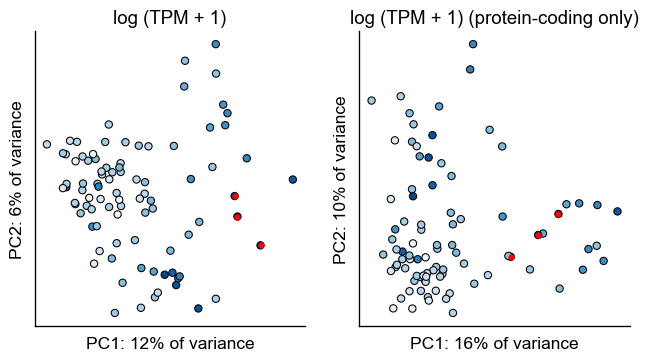

In [47]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize = (8, 4))

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=2)
for i, label in enumerate(['log_1p', 'log_1p_protein']):
    
    data = pca_dict[label][['PC1', 'PC2']].copy()
    
    # add in housekeeping data
    data['housekeeping'] = housekeeping_mean.loc[data.index]
    
    # plot data
    points = tpm_axes[i].scatter(data['PC1'], data['PC2'], c=data['housekeeping'],
                                 cmap=plt.get_cmap('Blues'), norm = norm, edgecolor = 'black', s = 30)
    
    removed = data.loc[removed_samples]
    points = tpm_axes[i].scatter(removed['PC1'], removed['PC2'], c = 'red', edgecolor = None, s = 15)
    
    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis='both', which='both', length = 0)
    
    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel('PC1: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[0]*100))
    tpm_axes[i].set_ylabel('PC2: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[1]*100))
    tpm_axes[i].set_title(['log (TPM + 1)', 'log (TPM + 1) (protein-coding only)', 'log (TPM + 1) (hvg)'][i])
    
    sns.despine(bottom = False, left = False)
    
tpm_fig.savefig('images/cwas/tpm-pca-matrix.png', bbox_inches = 'tight')

I mean... meh, right? Clearly these samples are slight outliers, but I see no reason to believe they're extremely abnormal. I don't see a frank need to remove them. So we keep all 89 samples.

## Adrenal signature

One important component of this analysis is that we have no idea of the underlying purity of these samples. This could be a pretty big problem, as eventually we'll be ranking these samples by expression. If a subset of samples have consistently low purity and these genes are relevant in an adrenal context, then we could get skewed results.

One way to check this is to devise an expression signature that is derived from adrenal-specific genes. This could (theoretically) help us control for these effects downstream. Maybe.

In [49]:
adrenal_genes = pd.read_csv('ref/adrenal-specific-genes.txt', sep='\t', comment = '#')['Gene Name'].tolist()
print(adrenal_genes)

['CYP17A1', 'CHGB', 'CYP11B1', 'STAR', 'HSD3B2', 'AKR1B1', 'CYP21A2', 'NOV', 'FDX1', 'DBH', 'SOAT1', 'MGARP', 'TH', 'AS3MT', 'PNMT', 'VWA5B2', 'MCOLN3', 'ARHGAP36', 'CARTPT', 'CYP11B2', 'KCNK2', 'CHRNA3', 'MC2R', 'SLC18A1', 'MAP3K15', 'PHOX2A', 'RET', 'FAM19A4', 'AP000783.1', 'C18orf42', 'AC015660.1', 'PHOX2B', 'FAM43B', 'DRGX', 'UCP1']


In [50]:
merged_tpms_pc_gsea = merged_tpms_protein_coding.set_index('gene_symbol').iloc[:, 2:]
merged_tpms_pc_gsea.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,13.371365,7.458475,16.812866,26.645397,4.260488,12.268498,12.030655,9.01669,22.009318,17.438509,12.494672,12.474228,5.98563,19.234141,12.572486,17.233388,28.389828,15.093672,6.492729,17.001738,7.982832,12.501859,36.167566,12.895066,21.734756,45.031394,18.754089,27.487045,17.248522,11.008326,40.932662,9.659539,8.078493,8.503080,9.462301,32.228893,12.300013,13.597521,22.357115,24.351058,18.937078,21.477597,35.373366,12.298143,15.968089,41.23376,14.762318,22.104827,19.800499,20.090890,16.490749,29.011792,15.849597,17.91214,26.242139,14.925513,20.689594,7.206234,19.938861,25.903271,17.608834,18.658268,18.877963,6.368619,16.580955,10.888372,15.481078,12.115863,8.410188,13.207728,48.682937,56.050621,16.449966,18.001097,15.550149,10.397539,22.228091,7.567005,9.337225,11.745586,15.903369,15.366313,42.228962,23.961827,10.793547,17.017862,16.736601,42.579061,27.269844
TNMD,0.111119,0.000000,0.366221,0.000000,0.277858,0.344782,0.119115,0.00000,0.112868,0.191933,0.143617,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.134166,0.000000,0.000000,0.000000,0.538873,0.000000,0.196871,0.000000,0.000000,0.124612,0.000000,0.232639,0.087599,0.369714,0.079502,0.000000,0.238683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101794,0.000000,0.095617,0.00000,0.000000,0.000000,6.192156,0.119234,0.448931,0.346128,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295326,0.097858,0.426965,0.273499,0.000000,0.136789,0.000000,0.000000,0.000000,0.000000,0.000000,0.308433,0.000000,0.000000,0.422912,0.000000,0.000000,0.000000,0.000000,0.556198,0.000000,0.234345,0.000000,0.000000,0.000000,0.000000,0.106152,0.127387,0.000000


In [51]:
ss = gp.ssgsea(data=merged_tpms_pc_gsea,
                   gene_sets={'adrenal': adrenal_genes},
                   outdir=None,
                   sample_norm_method='rank',
                   no_plot=True,
                   min_size=4)

adrenal_signature = ss.res2d
adrenal_signature.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

2023-12-07 21:12:51,276 [WARNING] Found duplicated gene names, values averaged by gene names!


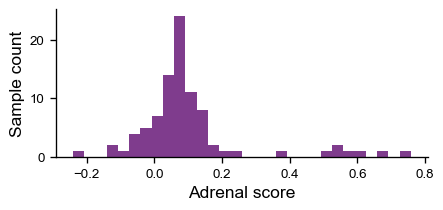

In [52]:
fig, ax = plt.subplots(1, figsize = (5, 2))
plt.hist(adrenal_signature['normalized_enrichment_score'], bins = 30);
ax.set_xlabel('Adrenal score')
ax.set_ylabel('Sample count')
sns.despine()
fig.savefig('images/cwas/adrenal-specific-expression.png', bbox_inches = 'tight')

So there's definitely some variation there. This will be important to keep in mind.

## One last filter -- expression

Since we'll be comparing expression between different samples, we should remove genes that have extremely low expression. This is akin to the filtering that is done in DESeq. We'll only keep genes that have more than 10 counts in more than 5 samples.

We also remove genes that have 0 expression in more than 20% of our samples. This can substantially derail ranking that happens later--a sample with 0 expression can have a decently high rank given the way we handle ties.

In [53]:
expressed = (merged_counts[included_samples] >= 10).sum(axis = 1) >= 5
min_greater_than_zero = (merged_tpms[included_samples] == 0).mean(axis = 1) <= 0.20

kept_rows = expressed & min_greater_than_zero

kept_gene_ids = merged_counts[expressed & min_greater_than_zero]['gene_id'].tolist()

# Framework for thinking about expression

Let's pause for a second and think about how we want to approach these data. Effectively in this process, we're going to end up with the following:

```
For each category
    for each SV
        for each gene affected by that SV (usually 1)
            expression values for each sample + whether that sample has the SV
```

It's easy enough to generate a rank from that list and identify the rank of samples with the SV compared to samples without the SV. But one of the underlying issues is directionality--if there is an effect of the SV, we have no way of knowing if it's up or down. 

One way to handle this is to use the absolute difference from the median, but this obfuscates differences within an individual sample. For now, let's just store the rank and see what happens.

## Handling the ranks

We use `scipy.stats.rankdata` to handle ties. Ties aren't technically allowed by the uniform distribution, but we'll use the metric of assigning the average, because that probably approximates things a bit better.

In [54]:
# converts ties to average rank/
stats.rankdata([0, 3, 1, 0])

array([1.5, 4. , 3. , 1.5])

# Try a coding example

This analysis is naturally most relevant for coding examples. Let's example the top coding hit:

In [55]:
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

In [56]:
test_framework = nbl_framework_results.query('af_category == "singleton" & sv_category == "coding"').loc[0, ["category_name"]].item()
framework_components = test_framework.split(".")
genic_relationship = framework_components[2]
test_framework, genic_relationship

('ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP')

So we need to do the following:

1. Identify the SVs that are part of this category
2. Identify the genes that are affected by these SVs
3. Quantify the expression in samples with the SV compared to samples without (will almost always be 1 vs. 88, or something like that)

We do this for all SVs in the category, and we can derive some summary metric.

In [57]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "coding") & 
                                   (nbl_category_svs["category"] == test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [58]:
genic_rel = genic_relationship.split("_or_")
genic_rel

['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']

In [59]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), included_samples]
)
nbl_sv_dosages.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_80,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this case, we're not going to drop samples that have poor genotyping. We'll just drop samples that aren't genotyped for our SV of interest, and we'll drop SVs without a count.

In [60]:
nbl_sv_dosages.shape

(3837, 89)

In [61]:
kept_svs = nbl_sv_dosages.fillna(0).sum(axis = 1) > 0
nbl_sv_dosages = nbl_sv_dosages.loc[kept_svs, :]

In [62]:
nbl_sv_dosages.shape

(59, 89)

So we basically lose all our SVs when we drop the majority of samples. Makes sense. Now, we approach the genes in question.

In [63]:
genes_in_svs = svs_in_category.set_index('name').loc[nbl_sv_dosages.index, genic_rel]
genes_in_svs.head(2)

,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP
ID,,
PedSV.2.5.2_DEL_chr1_833,TPRG1L,NaN
PedSV.2.5.2_DEL_chr1_6558,ACADM,NaN


We now need to go through and build our data. We drop genes that have no or very low expression. After some downstream work, I've also concluded that it's worth it to remove genes that have a substantial fraction of samples with no expression. This throws off ranking later (a gene with no expression in many samples can cause a sample with no expression to have a reasonably high rank).

In [64]:
tpms = merged_tpms.set_index('gene_id').loc[kept_gene_ids].set_index('gene_symbol').iloc[:, 1:]
tpms = tpms.loc[tpms.sum(axis = 1) > 0, :]
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [65]:
category_expression_results = []
for sv_name, row in genes_in_svs.iterrows():
    
    # get the dosage of the SV
    sv_dosages = nbl_sv_dosages.loc[sv_name]
    
    # drop samples that aren't genotyped
    sv_dosages = sv_dosages.dropna()
    
    # get the samples with the SV
    samples_with_sv = sv_dosages[sv_dosages > 0].index
    
    for col in genic_rel:
        if pd.isnull(row[col]):
            continue
            
        for gene in row[col].split(','):
            if gene not in list(tpms.index):
                print(gene + ' not in TPMs')
                continue
            
            # get the expression values
            gene_expression = tpms.loc[gene, sv_dosages.index]
            
            # handle gene name duplicates. Choose the one that is more expressed.
            if len(gene_expression.shape) > 1:
                sorted_values = tpms.loc[gene, sv_dosages.index].mean(axis = 1)
                gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]
                
            # calculate an average expression for qc later
            avg_expression = np.mean(gene_expression)
                
            # now rank the expression of the genes and look up the ranks of the
            # samples with SVs. Normalize by number of samples analyzed.
            ranked_expression = (gene_expression.rank(ascending = False) - 1) / (len(gene_expression) - 1)
            sv_ranks = ranked_expression.loc[samples_with_sv]
    
            # get the average SV rank (to handle multiple samples with the SV, uncommon)
            average_sv_rank = sv_ranks.mean()
            
            # store our data
            storage_row = [sv_name, col, gene, avg_expression, average_sv_rank]
            category_expression_results.append(storage_row)
            
category_expression_results = pd.DataFrame(category_expression_results, columns = ['sv_name', 'genic_relationship', 'gene', 'mean_exp', 'mean_rank_of_sample_w_sv'])

ODR4 not in TPMs
SANBR not in TPMs
CGAS not in TPMs
DEFB130B not in TPMs
DEFB134 not in TPMs
DEFB135 not in TPMs
DEFB136 not in TPMs
ZNF705D not in TPMs
INSL6 not in TPMs
PALM2AKAP2 not in TPMs
C8G not in TPMs
LGALS12 not in TPMs
PLAAT2 not in TPMs
PLAAT3 not in TPMs
PLAAT4 not in TPMs
CYP19A1 not in TPMs
MYH4 not in TPMs
CIMIP4 not in TPMs


In [66]:
category_expression_results['mean_rank_of_sample_w_sv'].mean()

0.646276479359471

In [67]:
category_expression_results.shape

(54, 5)

So if we assume the directionality of these effects is all the same direction, this is not a significant result.

We can, however, try to account for the directionality of results by looking at the deviation from the median rank (0.50). This should be 0.25 if there is no effect.

In [68]:
# before testing, we should drop all duplicate SV - gene pairs (happens when the same SV affects a gene in two different categories)
category_expression_results = category_expression_results.drop_duplicates(subset = ['sv_name', 'gene'])

In [69]:
category_expression_results['abs_rank_dev'] = np.abs(0.5 - category_expression_results['mean_rank_of_sample_w_sv'])

In [70]:
category_expression_results['abs_rank_dev'].mean()

0.3144582975412892

Interesting... this _is_ a significant result. I'll formulate the exact specifics later, but the distribution of deviation from the mean rank is well defined, and in this distribution, 0.29 corresponds to `p = 0.013`.

(array([ 2.,  5.,  3.,  3.,  2.,  8.,  2., 13.,  4.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <BarContainer object of 9 artists>)

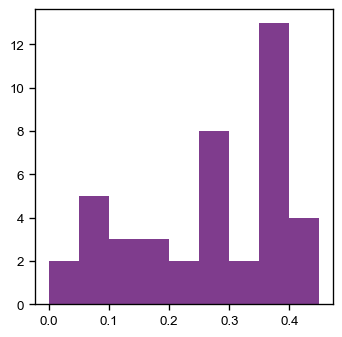

In [71]:
plt.hist(category_expression_results['abs_rank_dev'], bins = np.arange(0, 0.5, 0.05))

We can use a KS test to compare this to a uniform distribution:

In [72]:
# this compares the data distribution to uniform distribution along [0, 0.5], which is what it
# would be if the ranks were uniform
stats.kstest(category_expression_results['abs_rank_dev'], lambda x: 2 * x)

KstestResult(statistic=0.24579124579124584, pvalue=0.0023323738712721642)

In [73]:
category_expression_results['abs_rank_dev'].mean()

0.3144582975412892

In [74]:
# similarly, we can calculate the sample mean p value, since we have a sample mean
num_genes = category_expression_results.shape[0]
ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))

In [75]:
1 - ref_dist.cdf(category_expression_results['abs_rank_dev'].mean())

0.0005159518238152527

Neat!

# Try a noncoding example

The noncoding examples are... much harder. We expect them to have substantially less effect on expression compared to their coding counterparts.

I'm going to delete most of the text from the following code. It just follows the same as above.

In [76]:
nbl_noncoding_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_835,chr1,21344570,21344654,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,non-coding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,non-coding


In [77]:
# we'll select a non-tad framework for testing
nontad_test_framework = nbl_framework_results[(nbl_framework_results['af_category'] == "singleton") & 
                                              (nbl_framework_results['sv_category'] == "non-coding") &
                                              (~nbl_framework_results['category_name'].str.contains('tad'))].iloc[0]['category_name']

framework_components = nontad_test_framework.split(".")
genic_relationship = framework_components[2]
nontad_test_framework, genic_relationship

('ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY.ANY.ANY.protein_coding',
 'ANY')

In [78]:
nbl_framework_results.query('category_name == "ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY.ANY.ANY.protein_coding"')

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
16,0.264388,0.058728,4.5019,0.000007,339,5,388,646,1950,5,3174,4698,359,ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY...,ANY,SINGLETON,0.524768,0.41507,0.428331,5.17167,singleton,non-coding


In [79]:
nbl_noncoding_framework.head(6)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN


In [80]:
genic_relationships = ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

# a weird feature of these data is that PREDICTED_INTERGENIC is actually boolean, and refers to PREDICTED_NEAREST_TSS
genic_relationships[genic_relationships.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'

In [81]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "non-coding") & 
                                   (nbl_category_svs["category"] == nontad_test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [82]:
svs_in_category.shape

(3021, 952)

In [83]:
svs_in_category[genic_relationships].head()

,PREDICTED_NEAREST_TSS,PREDICTED_INTRONIC,PREDICTED_PROMOTER,PREDICTED_UTR
120,NaN,NaN,C1orf159,NaN
137,TTLL10,NaN,NaN,NaN
224,NaN,ATAD3B,NaN,NaN
584,NaN,NaN,C1orf174,NaN
836,HES3,NaN,NaN,NaN


In [84]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), included_samples]
)
nbl_sv_dosages.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
nbl_sv_dosages.shape

(3021, 89)

In [86]:
kept_svs = nbl_sv_dosages.fillna(0).sum(axis = 1) > 0
nbl_sv_dosages = nbl_sv_dosages.loc[kept_svs, :]

In [87]:
nbl_sv_dosages.shape

(48, 89)

In [88]:
genes_in_svs = svs_in_category.set_index('name').loc[nbl_sv_dosages.index, genic_relationships]
genes_in_svs.head(2)

,PREDICTED_NEAREST_TSS,PREDICTED_INTRONIC,PREDICTED_PROMOTER,PREDICTED_UTR
ID,,,,
PedSV.2.5.2_DEL_chr1_1438,ENO1,NaN,NaN,NaN
PedSV.2.5.2_DEL_chr1_2117,NaN,NaN,SPEN,NaN


In [89]:
tpms = merged_tpms.set_index('gene_id').loc[kept_gene_ids].set_index('gene_symbol').iloc[:, 1:]
tpms = tpms.loc[tpms.sum(axis = 1) > 0, :]
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [90]:
category_expression_results = []
for sv_name, row in genes_in_svs.iterrows():
    
    # get the dosage of the SV
    sv_dosages = nbl_sv_dosages.loc[sv_name]
    
    # drop samples that aren't genotyped
    sv_dosages = sv_dosages.dropna()
    
    # get the samples with the SV
    samples_with_sv = sv_dosages[sv_dosages > 0].index
    
    for col in genic_relationships:
        if pd.isnull(row[col]):
            continue
            
        for gene in row[col].split(','):
            if gene not in list(tpms.index):
                print(gene + ' not in TPMs')
                continue
            
            # get the expression values
            gene_expression = tpms.loc[gene, sv_dosages.index]
            
            # handle gene name duplicates. Choose the one that is more expressed.
            if len(gene_expression.shape) > 1:
                sorted_values = tpms.loc[gene, sv_dosages.index].mean(axis = 1)
                gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]
                
            # calculate an average expression for qc later
            avg_expression = np.mean(gene_expression)
                
            # now rank the expression of the genes and look up the ranks of the
            # samples with SVs
            ranked_expression = (gene_expression.rank(ascending = False) - 1) / (len(gene_expression) - 1)
            sv_ranks = ranked_expression.loc[samples_with_sv]
            
            # get the average SV rank (to handle multiple samples with the SV, uncommon)
            average_sv_rank = sv_ranks.mean()
            
            # store our data
            storage_row = [sv_name, col, gene, avg_expression, average_sv_rank]
            category_expression_results.append(storage_row)
            
category_expression_results = pd.DataFrame(category_expression_results, columns = ['sv_name', 'genic_relationship', 'gene', 'mean_exp', 'mean_rank_of_sample_w_sv'])

FOXQ1 not in TPMs
GJE1 not in TPMs
AGR3 not in TPMs
NKAIN3 not in TPMs
TPD52L3 not in TPMs
NALF1 not in TPMs
TMEM235 not in TPMs
APOC4 not in TPMs


In [91]:
category_expression_results['mean_rank_of_sample_w_sv'].mean()

0.45883013171004344

This is a less interesting result.

In [92]:
category_expression_results['abs_rank_dev'] = np.abs(0.5 - category_expression_results['mean_rank_of_sample_w_sv'])

In [93]:
category_expression_results['abs_rank_dev'].mean()

0.24267286943209157

In [94]:
# before testing, we should drop all duplicate SV - gene pairs (happens when the same SV affects a gene in two different categories)
category_expression_results = category_expression_results.drop_duplicates(subset = ['sv_name', 'gene'])

(array([3., 4., 5., 7., 3., 3., 3., 6., 3.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <BarContainer object of 9 artists>)

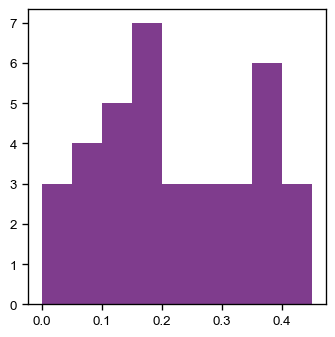

In [95]:
plt.hist(category_expression_results['abs_rank_dev'], bins = np.arange(0, 0.5, 0.05))

In [96]:
# this compares the data distribution to uniform distribution along [0, 0.5], which is what it
# would be if the ranks were uniform
stats.kstest(category_expression_results['abs_rank_dev'], lambda x: 2 * x)

KstestResult(statistic=0.09318181818181814, pvalue=0.8463375375863285)

# Generalize | Also, convert to normal test

Alright, here we go. This is going to be a bit complicated, but it shouldn't be difficult.

In [97]:
nbl_analysis_categories = nbl_framework_results.query('negative_log10_p_value > 3.5')
nbl_analysis_categories.shape

(77, 22)

In [175]:
nbl_framework_results

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding
2,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding
3,0.229239,0.046251,4.956454,7.180000e-07,530,5,290,644,3101,5,2513,4700,576,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,ANY,SINGLETON,0.822981,0.659787,0.679454,6.143928,singleton,coding
4,0.319613,0.074686,4.279405,1.870000e-05,210,4,470,646,1142,3,3713,4700,218,ANY.SINGLETON.ANY.unconstrained.ANY.protein_co...,ANY,SINGLETON,0.325077,0.242979,0.252899,4.727246,singleton,coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0.000600,0.203441,0.002947,9.976483e-01,25,3,667,688,186,2,4660,4831,17,ANY.RARE.ANY.neuroblastoma_chromHMM15_TssAFlnk...,ANY,RARE,0.036337,0.038501,0.038232,0.001023,rare,non-coding
2908,-0.001106,0.378248,-0.002923,9.976679e-01,8,1,680,688,58,2,4774,4831,7,ANY.RARE.ANY.neuroblastoma_ABC_MAX_enhancer.PR...,ANY,RARE,0.011628,0.012006,0.011959,0.001014,rare,non-coding
2909,0.000328,0.186907,0.001756,9.985993e-01,32,1,656,688,228,2,4616,4831,19,CPX_or_INV.RARE.PREDICTED_NONCODING_BREAKPOINT...,CPX_or_INV,RARE,0.046512,0.047195,0.047110,0.000609,rare,non-coding
2910,-0.000169,0.202972,-0.000831,9.993373e-01,26,2,659,683,186,2,4654,4827,17,ANY.RARE.ANY.neuroblastoma_tad_boundary.PREDIC...,ANY,RARE,0.038067,0.038533,0.038475,0.000288,rare,non-coding


In [98]:
gr_coding_mapping = {'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP': ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP'],
                     'ANY': ['PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']}

gr_noncoding_mapping = {'ANY': ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']}


In [99]:
tpms = merged_tpms.set_index('gene_id').loc[kept_gene_ids].set_index('gene_symbol').iloc[:, 1:]
tpms = tpms.loc[tpms.sum(axis = 1) > 0, :]
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [725]:
expression_results = []
sv_gene_results = []

for i, (index, row) in enumerate(nbl_analysis_categories.iterrows()):
    print(i, end = ', ')
    cat_name = row['category_name']
    af_category = row['af_category']
    sv_category = row['sv_category']
    p_category = row['p_value']
    
    cat_components = cat_name.split('.')
    
    base_row = [cat_name, af_category, sv_category, p_category]
    
    # here, we define the necessary genic relationships
    # we handle the collapsed categories as well
    if sv_category == 'coding':
        gr = cat_components[2]

        # convert gr to components
        genic_rel = gr_coding_mapping.get(gr, [gr])
        
    elif sv_category == 'non-coding':
        gr = cat_components[4]

        # convert gr to components
        genic_rel = gr_noncoding_mapping.get(gr, [gr])
        
    # swap out intergenic for nearest_tss
    if 'PREDICTED_INTERGENIC' in genic_rel:
        genic_rel[genic_rel.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'
        
    # next, we pull out our SVs in this category
    svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == sv_category) & 
                                       (nbl_category_svs["category"] == cat_name)]
    
    # subset the actual SV matrix
    svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]
    
    # extract the dosages
    nbl_sv_dosages = (
        dosages
        .set_index("ID")
        .loc[svs_in_category["name"].tolist(), included_samples]
        )
    
    # drop SVs with no counts
    kept_svs = nbl_sv_dosages.fillna(0).sum(axis = 1) > 0
    nbl_sv_dosages = nbl_sv_dosages.loc[kept_svs, :]
    
    if len(nbl_sv_dosages) == 0:
        print(cat_name, ' has no RNA samples with any SVs')
        continue
    
    # define our genes
    genes_in_svs = svs_in_category.set_index('name').loc[nbl_sv_dosages.index, genic_rel]
    
    category_exp_results = []
    for sv_name, row in genes_in_svs.iterrows():
        
        # get the dosage of the SV
        sv_dosages = nbl_sv_dosages.loc[sv_name]
        sv_dosages = sv_dosages.dropna()
        
        # get the samples with the SV
        samples_with_sv = list(sv_dosages[sv_dosages > 0].index)
        samples_with_sv_str = ' | '.join(samples_with_sv)
        
        # loop through an examine the genes
        for col in genic_rel:
            if pd.isnull(row[col]):
                continue
            
            for gene in row[col].split(','):
                if gene not in list(tpms.index):
                    continue
                    
                # get the expression values
                gene_expression = tpms.loc[gene, sv_dosages.index]
                
                # handle gene name duplicates. Choose the one that is more expressed.
                if len(gene_expression.shape) > 1:
                    sorted_values = tpms.loc[gene, sv_dosages.index].mean(axis = 1)
                    gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]
                    
                # calculate an average expression for qc later
                avg_expression = np.mean(gene_expression)

                # now rank the expression of the genes and look up the ranks of the
                # samples with SVs
                ranked_expression = (gene_expression.rank(ascending = False) - 1) / (len(gene_expression) - 1)
                sv_ranks = ranked_expression.loc[samples_with_sv]
                
                # get the average SV rank (to handle multiple samples with the SV, uncommon)
                average_sv_rank = sv_ranks.mean()

                # store our data
                storage_row = base_row + [sv_name, samples_with_sv_str, col, gene, avg_expression, average_sv_rank]
                category_exp_results.append(storage_row)
                sv_gene_results.append(storage_row)
                
    # calculate the average absolute and deviation rank
    temp = pd.DataFrame(category_exp_results)
    
    # drop observations of the same SV and gene, as
    temp = temp.drop_duplicates(subset = [4, 7])
    
    # calculate the mean normalized rank
    mean_abs_rank = np.mean(temp.iloc[:, -1])
    
    rank_deviation = np.abs(0.5 - temp.iloc[:, -1])
    mean_dev_rank = np.mean(rank_deviation)
    num_genes = temp.shape[0]
    
    total_storage_row = base_row + [num_genes, mean_abs_rank, mean_dev_rank]
    
    # now we do some statistics. A KS test, to start
    p_ks = stats.kstest(rank_deviation, lambda x: 2 * x)[1]
    
    # now do the sample mean test
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p_mean = 1 - ref_dist.cdf(mean_dev_rank)
    
    total_storage_row += [p_ks, p_mean]
    
    expression_results.append(total_storage_row)
    
fine_result_names = ['category', 'af_category', 'sv_category', 'category_p', 'sv_name', 'samples_w_sv', 'genic_rel', 'gene', 'avg_exp', 'sv_rank']
sv_gene_results = pd.DataFrame(sv_gene_results, columns = fine_result_names)

broad_result_names = ['category', 'af_category', 'sv_category', 'category_p', 'num_svs', 'mean_abs_rank', 'mean_dev_rank', 'p_ks', 'p_mean']
expression_results = pd.DataFrame(expression_results, columns = broad_result_names)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary_conserved.ANY.ANY.ANY.cosmic_and_germline_CPGs  has no RNA samples with any SVs
40, DEL.SINGLETON.ANY.neuroblastoma_tad_boundary_conserved.ANY.ANY.ANY.cosmic_and_germline_CPGs  has no RNA samples with any SVs
41, 42, 43, 44, 45, 46, 47, 48, 49, ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_chromHMM15_EnhBiv.PREDICTED_INTRONIC.lof_constrained.ANY.protein_coding  has no RNA samples with any SVs
50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 

In [100]:
expression_results.to_csv('data/cwas-results/expression-significance.csv', index=False)
sv_gene_results.to_csv('data/cwas-results/sv-gene-expression-results.csv', index=False)

NameError: name 'expression_results' is not defined

In [101]:
expression_results = pd.read_csv('data/cwas-results/expression-significance.csv')
sv_gene_results = pd.read_csv('data/cwas-results/sv-gene-expression-results.csv')

But how many unique SVs are in these categories? I imagine there's a substantial degree of overlap.

In [184]:
unique_sig_svs = set()
for index, row in expression_results.query('p_mean < 0.05').iterrows():
    cat = row['category']
    val = sv_gene_results.query(f'category == "{cat}"')['sv_name']
    unique_sig_svs.update(list(val))
    
len(unique_sig_svs)

61

Right, that makes sense. The significance of these categories is actually picking up on a smaller number of SVs.

In [767]:
for index, row in expression_results.query('p_mean < 0.05').iterrows():
    print(row['category'])

ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
DEL.SINGLETON.ANY.ANY.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding


In [104]:
expression_results.query('p_mean < 0.05')

,category,af_category,sv_category,category_p,num_svs,mean_abs_rank,mean_dev_rank,p_ks,p_mean
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,54,0.646276,0.314458,0.002332,0.000516
1,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,3.190000e-07,47,0.666491,0.318618,0.002839,0.000559
2,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,3.190000e-07,47,0.666491,0.318618,0.002839,0.000559
3,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,7.180000e-07,68,0.639640,0.308290,0.001320,0.000434
4,ANY.SINGLETON.ANY.unconstrained.ANY.protein_co...,singleton,coding,1.870000e-05,34,0.652293,0.302828,0.117008,0.016416
5,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,4.860000e-05,22,0.695271,0.364486,0.001821,0.000099
6,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,5.320000e-05,25,0.672800,0.322073,0.014854,0.006268
7,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,singleton,coding,6.360000e-05,30,0.636191,0.339828,0.002790,0.000326
8,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,singleton,coding,1.950000e-04,21,0.715726,0.337154,0.018582,0.002828
9,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.950000e-04,21,0.715726,0.337154,0.018582,0.002828


In [105]:
expression_results.query('p_mean < 0.05')

,category,af_category,sv_category,category_p,num_svs,mean_abs_rank,mean_dev_rank,p_ks,p_mean
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,54,0.646276,0.314458,0.002332,0.000516
1,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,3.190000e-07,47,0.666491,0.318618,0.002839,0.000559
2,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,3.190000e-07,47,0.666491,0.318618,0.002839,0.000559
3,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,7.180000e-07,68,0.639640,0.308290,0.001320,0.000434
4,ANY.SINGLETON.ANY.unconstrained.ANY.protein_co...,singleton,coding,1.870000e-05,34,0.652293,0.302828,0.117008,0.016416
5,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,4.860000e-05,22,0.695271,0.364486,0.001821,0.000099
6,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,5.320000e-05,25,0.672800,0.322073,0.014854,0.006268
7,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,singleton,coding,6.360000e-05,30,0.636191,0.339828,0.002790,0.000326
8,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,singleton,coding,1.950000e-04,21,0.715726,0.337154,0.018582,0.002828
9,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.950000e-04,21,0.715726,0.337154,0.018582,0.002828


# Validate some of these findings

Let's take a look at some of these genes. We'll examine the one with the most significant findings:

In [106]:
expression_results.query('category == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"')

,category,af_category,sv_category,category_p,num_svs,mean_abs_rank,mean_dev_rank,p_ks,p_mean
5,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,0.000049,22,0.695271,0.364486,0.001821,0.000099


In [107]:
val = sv_gene_results.query('category == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"')
val.head(2)

,category,af_category,sv_category,category_p,sv_name,samples_w_sv,genic_rel,gene,avg_exp,sv_rank
250,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,0.000049,PedSV.2.5.2_DEL_chr1_833,PT_4Y3P2N1P,PREDICTED_LOF,TPRG1L,7.245281,0.897727
251,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,0.000049,PedSV.2.5.2_DEL_chr1_6558,PT_GSWXPFPQ,PREDICTED_LOF,ACADM,24.638539,0.954545


In [108]:
val.shape

(22, 10)

2.55
0.8876404494382022


(array([30., 35., 12.,  4.,  1.,  4.,  0.,  2.,  0.,  1.]),
 array([ 0.97 ,  4.325,  7.68 , 11.035, 14.39 , 17.745, 21.1  , 24.455,
        27.81 , 31.165, 34.52 ]),
 <BarContainer object of 10 artists>)

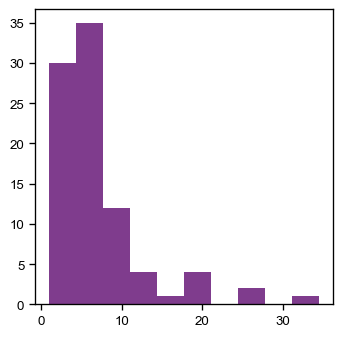

In [109]:
test = tpms.loc['TPRG1L']
s = 'PT_4Y3P2N1P'
print(test.loc[s])
print(test[test > test.loc[s]].shape[0] / len(test))
plt.hist(test)

In [110]:
val['sv_rank'].mean()

0.6952712140612268

That's a pretty substantial mean rank deviation. Let's examine the distribution of ranks:

<AxesSubplot:xlabel='% expression rank of sample with SV', ylabel='SV count'>

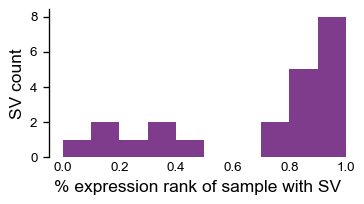

In [111]:
val = sv_gene_results.query('category == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"')
fig, ax = plt.subplots(1, figsize = (4, 2))
plt.hist(val['sv_rank'], bins = np.arange(0, 1.1, 0.1))
ax.set_xlabel('% expression rank of sample with SV')
ax.set_ylabel('SV count')
ax.set_xlim([-0.05, 1])
aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')

That's... extremely aggressive. This is suggesting that the vast majority of samples with a category SV are at the upper echelon of expression, which is extremely surprising.

In [112]:
sorted_values = val.sort_values(by = 'sv_rank').reset_index(drop=True)

In [114]:
genes = sorted_values['gene'].tolist()
heatmap_exp = tpms.loc[genes]
heatmap_cols = tpms.columns

# unfortunately, have to handle gene duplicates. So annoying
temp = []
for g in sorted(set(heatmap_exp.index)):
    exp = heatmap_exp.loc[g]
    if len(exp.shape) > 1:
        mean_exp = exp.mean(axis = 1)
        exp = exp.iloc[np.argmax(mean_exp), :]
    
    temp.append(exp)

heatmap_exp = pd.DataFrame(temp, index = sorted(set(heatmap_exp.index)))
heatmap_exp = heatmap_exp.loc[genes]
        
heatmap_exp = heatmap_exp.values

# we now need to scramble the rows by sorting by expression
ordered_indices = np.argsort(heatmap_exp, axis = 1)[:, ::-1]
heatmap_exp = np.sort(heatmap_exp, axis = 1)

# create a mask for 0 expression
mask = (heatmap_exp == 0)
masked_data = np.where(mask, heatmap_exp, np.nan)

# convert heatmap data to zscore
heatmap_exp = stats.zscore(heatmap_exp, axis = 1)

In [115]:
len(genes), heatmap_exp.shape

(22, (22, 89))

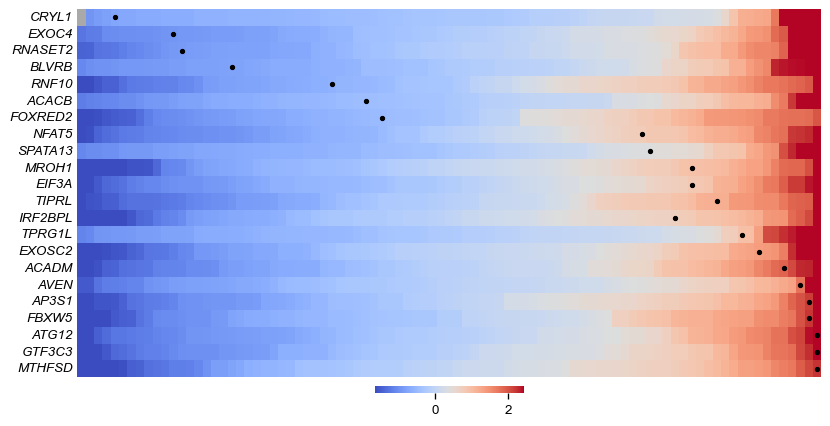

In [117]:
# make the figure and gridspec
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[0])

sns.heatmap(heatmap_exp, cmap="coolwarm", robust=True, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

# apply a mask for 0 expression
sns.heatmap(masked_data, cmap=['darkgrey'], annot=False, cbar=False, mask=~mask)

heatmap_ax.set_yticks(np.arange(len(genes)) + 0.5)
heatmap_ax.set_yticklabels(genes, rotation = 0, ha = 'right', fontstyle = 'italic');
aesthetics.strip_axis(ax = heatmap_ax, y = 'label')
heatmap_ax.tick_params(axis = 'y', length = 0)

# label the samples with SVs
for i, row in sorted_values.iterrows():
    samps_w_sv = row['samples_w_sv'].split(' | ')
    
    for s in samps_w_sv:
        sorted_s = heatmap_cols[ordered_indices[i, :]]
        s_idx = list(sorted_s).index(s)
        heatmap_ax.scatter(x = s_idx + 0.5, y = i + 0.5, color = 'black', s = 10)

In [204]:
# add a blank row for coding only - pretty messy
expression_results = pd.concat([expression_results, pd.DataFrame([np.nan] * len(expression_results.columns), index = expression_results.columns).T])

Now we generalize

In [208]:
coding_val = sv_gene_results[(sv_gene_results['sv_name'].isin(unique_sig_svs))].drop_duplicates(subset = 'sv_name')
mean_abs_rank = np.mean(coding_val['sv_rank'])
rank_deviation = np.abs(0.5 - coding_val['sv_rank'])
mean_dev_rank = np.mean(rank_deviation)
num_genes = coding_val['sv_rank'].shape[0]
    
# now we do some statistics. A KS test, to start
coding_p_ks = stats.kstest(rank_deviation, lambda x: 2 * x)[1]
    
# now do the sample mean test
ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
coding_p_mean = 1 - ref_dist.cdf(mean_dev_rank)

coding_p_ks, coding_p_mean

(0.00012651479834945421, 8.093860156477284e-05)

In [432]:
adipogenesis = gene_sets['Adipogenesis']

In [434]:
# generalize
for index, row in expression_results.iterrows():
    
    if index != list(expression_results.index)[-1]:
        continue
    
    category = row['category']
    
    cat_p = row['category_p']
    p_ks, p_mean = row[['p_ks', 'p_mean']].values
    
    val = sv_gene_results.query(f'category == "{category}"')
    
    if index == list(expression_results.index)[-1]:
        category = 'coding'
        val = sv_gene_results[(sv_gene_results['sv_name'].isin(unique_sig_svs))].drop_duplicates(subset = 'sv_name')
        p_ks, p_mean = coding_p_ks, coding_p_mean
        raise
    
    
    path = f'data/cwas-results/expression-plots/{category}'
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # get the distribution of ranks
    fig, axes = plt.subplots(2, 1, figsize = (4, 4), gridspec_kw = {'hspace': 0.5})
    
    for i, analysis in enumerate(['abs', 'dev']):
        if analysis == 'dev':
            data = np.abs(0.5 - val['sv_rank'])
            bins = np.arange(0, 0.55, 0.05)
            xlim = [-0.025, 0.50]
        else:
            data = val['sv_rank']
            bins = np.arange(0, 1.1, 0.1)
            xlim = [-0.05, 1.0]
        
        axes[i].hist(data, bins)
        label = '% expression rank of samples with SV' if analysis == 'abs' else 'rank deviation'  
        
        axes[i].set_xlabel(label)
        axes[i].set_ylabel('SV count')
        axes[i].set_xlim(xlim)
        aesthetics.strip_axis(ax = axes[i], x = 'label', y = 'ignore')
    
    p_label = "p_ks = {:.2g}\np_mean = {:.2g}".format(p_ks, p_mean)
    axes[0].text(x = 0.5, y = 0.75, s = p_label, transform = axes[0].transAxes, fontsize = 10, ha = 'center')
    axes[0].set_title(category, fontsize = 8)

    fig.savefig(path + '/expression-histogram.png', bbox_inches = 'tight')
    plt.close(fig)
    
    ###############
    ### HEATMAP ###
    ###############
    sorted_values = val.sort_values(by = 'sv_rank').reset_index(drop=True)
    sorted_values = sorted_values.drop_duplicates(subset = ['sv_name', 'gene'])
    
    genes = sorted_values['gene'].tolist()
    heatmap_exp = tpms.loc[genes]
    heatmap_cols = tpms.columns

    # unfortunately, have to handle gene duplicates. So annoying. Select the most expressed.
    temp = []
    for g in sorted(set(heatmap_exp.index)):
        exp = heatmap_exp.loc[g]
        if len(exp.shape) > 1:
            mean_exp = exp.mean(axis = 1)
            exp = exp.iloc[np.argmax(mean_exp), :]

        temp.append(exp)

    heatmap_exp = pd.DataFrame(temp, index = sorted(set(heatmap_exp.index)))
    heatmap_exp = heatmap_exp.loc[genes]

    heatmap_exp = heatmap_exp.values

    # we now need to scramble the rows by sorting by expression
    ordered_indices = np.argsort(heatmap_exp, axis = 1)[:, ::-1]
    heatmap_exp = np.sort(heatmap_exp, axis = 1)

    # create a mask for 0 expression
    mask = (heatmap_exp == 0)
    masked_data = np.where(mask, heatmap_exp, np.nan)

    # convert heatmap data to zscore
    heatmap_exp = stats.zscore(heatmap_exp, axis = 1)
    
    # make the figure and gridspec
    fig = plt.figure(figsize=(10, 0.25 * heatmap_exp.shape[0]))
    gs = fig.add_gridspec(1)

    # plot the heatmap
    heatmap_ax = fig.add_subplot(gs[0])

    sns.heatmap(heatmap_exp, cmap="coolwarm", robust=True, 
                ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

    # apply a mask for 0 expression
    sns.heatmap(masked_data, cmap=['darkgrey'], annot=False, cbar=False, mask=~mask)

    heatmap_ax.set_yticks(np.arange(len(genes)) + 0.5)
    heatmap_ax.set_yticklabels(genes, rotation = 0, ha = 'right', fontstyle = 'italic');
    aesthetics.strip_axis(ax = heatmap_ax, y = 'label')
    heatmap_ax.tick_params(axis = 'y', length = 0)

    # label the samples with SVs
    for i, row in sorted_values.iterrows():
        samps_w_sv = row['samples_w_sv'].split(' | ')

        for s in samps_w_sv:
            sorted_s = heatmap_cols[ordered_indices[i, :]]
            s_idx = list(sorted_s).index(s)
            heatmap_ax.scatter(x = s_idx + 0.5, y = i + 0.5, color = 'black', s = 10)
            
    heatmap_ax.set_title(category, fontsize = 10)
    
    fig.savefig(path + '/expression-heatmap.png', bbox_inches = 'tight')
    plt.close(fig)

RuntimeError: No active exception to reraise

In [437]:
set(val['gene']) & set(adipogenesis)

{'ACADM'}

In [210]:
expression_results.query('p_mean < 0.05')

,category,af_category,sv_category,category_p,num_svs,mean_abs_rank,mean_dev_rank,p_ks,p_mean,-log10(cat_p),-log10(p_mean)
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,54.0,0.646276,0.314458,0.002332,0.000516,6.954677,3.287391
1,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,3.190000e-07,47.0,0.666491,0.318618,0.002839,0.000559,6.496209,3.252865
2,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,3.190000e-07,47.0,0.666491,0.318618,0.002839,0.000559,6.496209,3.252865
3,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,7.180000e-07,68.0,0.639640,0.308290,0.001320,0.000434,6.143876,3.362555
4,ANY.SINGLETON.ANY.unconstrained.ANY.protein_co...,singleton,coding,1.870000e-05,34.0,0.652293,0.302828,0.117008,0.016416,4.728158,1.784740
5,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,4.860000e-05,22.0,0.695271,0.364486,0.001821,0.000099,4.313364,4.002306
6,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,5.320000e-05,25.0,0.672800,0.322073,0.014854,0.006268,4.274088,2.202869
7,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,singleton,coding,6.360000e-05,30.0,0.636191,0.339828,0.002790,0.000326,4.196543,3.486328
8,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,singleton,coding,1.950000e-04,21.0,0.715726,0.337154,0.018582,0.002828,3.709965,2.548483
9,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.950000e-04,21.0,0.715726,0.337154,0.018582,0.002828,3.709965,2.548483


In [170]:
expression_results['-log10(cat_p)'] = -np.log10(expression_results['category_p'])
expression_results['-log10(p_mean)'] = -np.log10(expression_results['p_mean'])

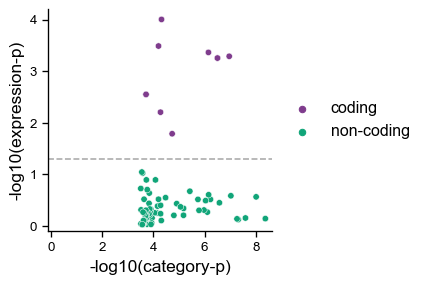

In [182]:
fig, ax = plt.subplots(1, figsize = (3, 3))
sns.scatterplot(x = '-log10(cat_p)', y = '-log10(p_mean)', data = expression_results, hue = 'sv_category')
ax.set_xlabel('-log10(category-p)')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([-0.1, None])
ax.set_ylim([-0.1, None])
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey')
ax.legend(bbox_to_anchor = (1, 0.5))
fig.savefig('data/cwas-results/expression-significance.png', bbox_inches = 'tight')

In [214]:
expression_results.groupby(['sv_category', 'af_category']).size()

sv_category  af_category
coding       singleton      10
non-coding   rare           29
             singleton      35
dtype: int64

In [440]:
for index, row in expression_results.query('p_mean < 0.05').iterrows():
    print(row['category'])

ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
DEL.SINGLETON.ANY.ANY.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding


# Need to look at eQTL analysis

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04307-0  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3682727/  
https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/tp201242#Sec2

# Riaz's TAD Boundaries

Riaz has taken a look at the TAD boundary categories and "expanded them" to include all genes in the TAD. So effectively, a count for an SV in the TAD boundary leads to a count for all the genes in a TAD.

He's identified a list of these genes and would like to know if the expression within these samples is systematically effected. Let's take a look.

In [443]:
riaz_tads = pd.read_csv('data/CWAS data for Jett/TAD_category_of_interest_SVs_in_cases_tibble_subsetted_with_TAD_boundaries_TADs_and_genes_unique_with_samples_and_study_12_2_23.txt', sep='\t')
riaz_tads.head(2)

,SV_name,TAD_boundary_ID,gene,sample,study
0,PedSV.2.5.2_DEL_chr1_832,TAD_boundary_15,ARHGEF16,PT_HA7TBZ1V,GMKF
1,PedSV.2.5.2_DEL_chr1_832,TAD_boundary_15,MEGF6,PT_HA7TBZ1V,GMKF


In [444]:
riaz_tads.shape

(916, 5)

In [445]:
len(set(riaz_tads['sample'])), len(set(riaz_tads['sample']) & set(included_samples))

(222, 35)

In [446]:
riaz_tads[riaz_tads['sample'].isin(included_samples)].shape

(105, 5)

In [447]:
subsamples = set(riaz_tads['sample']) & set(included_samples)
subgenes = riaz_tads[riaz_tads['sample'].isin(subsamples)]['gene']
print(len(subgenes), len(set(subgenes) & set(merged_tpms['gene_symbol'])))

105 96


And only 96 of the genes are in the TPM matrix.

In [448]:
len(subsamples)

35

So unfortunately, only about 10% of these SVs are in samples with valid RNA. With that said, let's take a look at them. Can we just spot check that these samples have the SV in question?

In [449]:
riaz_dosages = dosages.set_index('ID').loc[list(set(riaz_tads['SV_name']))]

In [450]:
for index, row in riaz_tads.iterrows():
    sv, s = row[['SV_name', 'sample']].values
    dose = riaz_dosages.loc[sv, s]
    
    assert dose == 1
    

Excellent.

In [451]:
tpms.head(2)

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [452]:
tpms.shape

(23262, 89)

In [453]:
tad_expression_results = []

for index, row in riaz_tads.iterrows():
    sv, tad, gene, sample = row[['SV_name', 'TAD_boundary_ID', 'gene', 'sample']].values
    
    if sample not in tpms.columns or gene not in tpms.index:
        continue
    
    sv_riaz_dose = riaz_dosages.loc[sv, included_samples].dropna()
    
    samples_with_sv = list(sv_riaz_dose[sv_riaz_dose > 0].index)
    samples_with_sv_str = ' | '.join(samples_with_sv)
    
    # get the expression values
    gene_expression = tpms.loc[gene, sv_riaz_dose.index]
    
    # handle gene name duplicates. Choose the one that is more expressed.
    if len(gene_expression.shape) > 1:
        sorted_values = gene_expression.mean(axis = 1)
        gene_expression = gene_expression.iloc[np.argmax(sorted_values), :]

    # calculate an average expression for qc later
    avg_expression = np.mean(gene_expression)

    # now rank the expression of the genes and look up the ranks of the
    # samples with SVs
    ranked_expression = (gene_expression.rank(ascending = False) - 1) / (len(gene_expression) - 1)
    sv_ranks = ranked_expression.loc[sample]

    # get the average SV rank (to handle multiple samples with the SV, uncommon)
    average_sv_rank = sv_ranks.mean()

    # store our data
    storage_row = [sv_name, samples_with_sv_str, tad, gene, avg_expression, average_sv_rank]
    tad_expression_results.append(storage_row)
    
tad_expression_results = pd.DataFrame(tad_expression_results, columns = ['SV_name', 'samples_with_sv', 'TAD_boundary_ID', 'gene', 'avg_exp', 'sv_rank'])

In [454]:
tad_expression_results['sv_rank'].mean()

0.4650662706924051

In [455]:
rank_deviation = np.abs(0.5 - tad_expression_results['sv_rank'])
mean_dev_rank = np.mean(rank_deviation)
num_genes = tad_expression_results.shape[0]

print(mean_dev_rank)

0.2599791013584118


In [456]:
# now we do some statistics. A KS test, to start
p_ks = stats.kstest(rank_deviation, lambda x: 2 * x)[1]

# now do the sample mean test
ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
p_mean = 1 - ref_dist.cdf(mean_dev_rank)

print(p_ks, p_mean)

0.48842812218033693 0.25019810167441003


So nominally, these are not significant.

In [457]:
# get the distribution of ranks
fig, axes = plt.subplots(2, 1, figsize = (4, 4), gridspec_kw = {'hspace': 0.5})

val = tad_expression_results.copy()
category = 'tad-boundaries'

path = f'data/cwas-results/expression-plots/{category}'
if not os.path.isdir(path):
    os.mkdir(path)

for i, analysis in enumerate(['abs', 'dev']):
    if analysis == 'dev':
        data = np.abs(0.5 - val['sv_rank'])
        bins = np.arange(0, 0.55, 0.05)
        xlim = [-0.025, 0.50]
    else:
        data = val['sv_rank']
        bins = np.arange(0, 1.1, 0.1)
        xlim = [-0.05, 1.0]

    axes[i].hist(data, bins)
    label = '% expression rank of samples with SV' if analysis == 'abs' else 'rank deviation'  

    axes[i].set_xlabel(label)
    axes[i].set_ylabel('SV count')
    axes[i].set_xlim(xlim)
    aesthetics.strip_axis(ax = axes[i], x = 'label', y = 'ignore')

p_label = "p_ks = {:.2g}\np_mean = {:.2g}".format(p_ks, p_mean)
axes[0].text(x = 0.5, y = 0.75, s = p_label, transform = axes[0].transAxes, fontsize = 10, ha = 'center')
axes[0].set_title(category, fontsize = 8)

fig.savefig(path + '/expression-histogram.png', bbox_inches = 'tight')
plt.close(fig)

In [458]:
sorted_values = val.sort_values(by = 'sv_rank').reset_index(drop=True)

genes = sorted_values['gene'].tolist()
heatmap_exp = tpms.loc[genes].values
heatmap_cols = tpms.columns

# unfortunately, we now need to scramble the rows by sorting by expression
ordered_indices = np.argsort(heatmap_exp, axis = 1)[:, ::-1]
heatmap_exp = np.sort(heatmap_exp, axis = 1)

# create a mask for 0 expression
mask = (heatmap_exp == 0)
masked_data = np.where(mask, heatmap_exp, np.nan)

# convert heatmap data to zscore
heatmap_exp = stats.zscore(heatmap_exp, axis = 1)

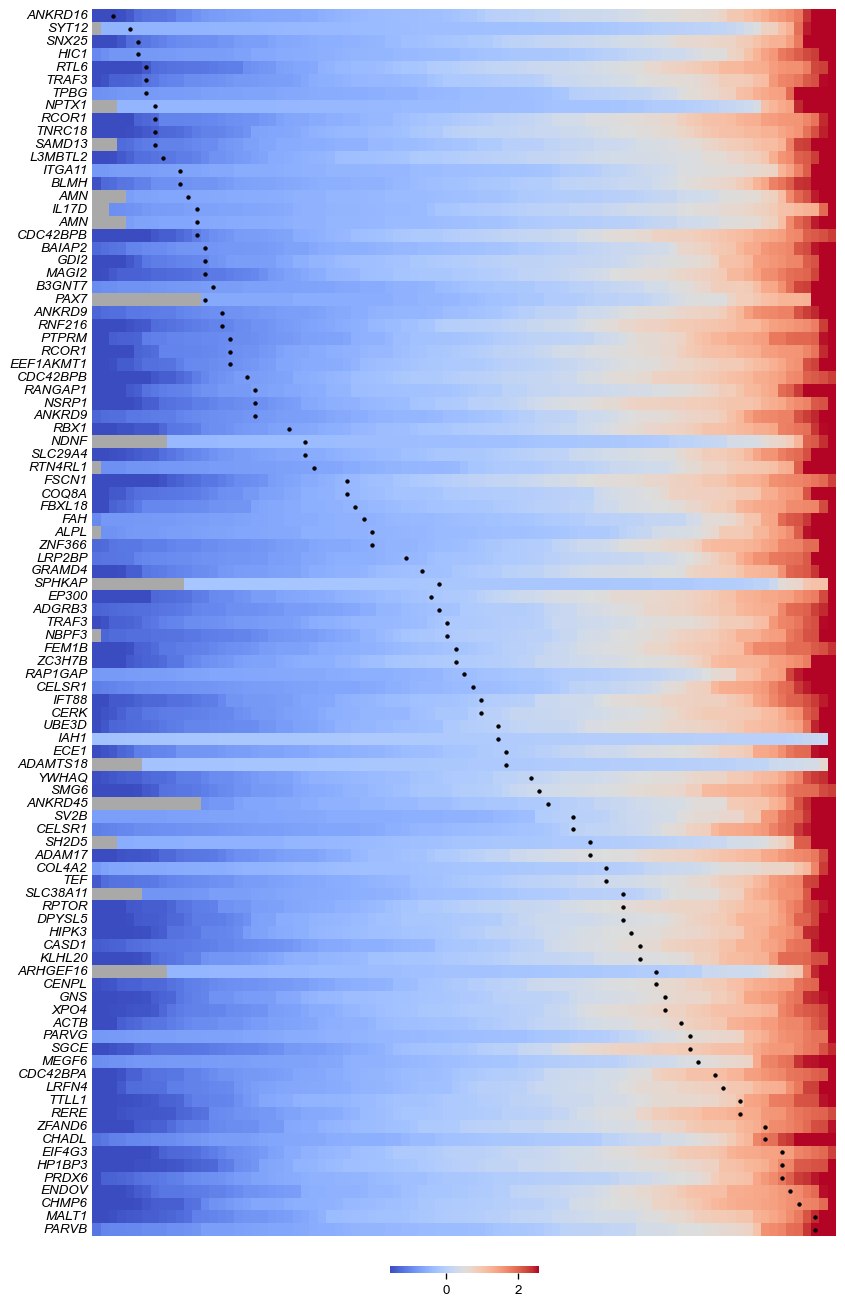

In [460]:
# make the figure and gridspec
fig = plt.figure(figsize=(10, 20))
gs = fig.add_gridspec(1)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[0])

sns.heatmap(heatmap_exp, cmap="coolwarm", robust=True, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

# apply a mask for 0 expression
sns.heatmap(masked_data, cmap=['darkgrey'], annot=False, cbar=False, mask=~mask)

heatmap_ax.set_yticks(np.arange(len(genes)) + 0.5)
heatmap_ax.set_yticklabels(genes, rotation = 0, ha = 'right', fontstyle = 'italic');
aesthetics.strip_axis(ax = heatmap_ax, y = 'label')
heatmap_ax.tick_params(axis = 'y', length = 0)

# label the samples with SVs
for i, row in sorted_values.iterrows():
    samps_w_sv = row['samples_with_sv'].split(' | ')
    
    for s in samps_w_sv:
        sorted_s = heatmap_cols[ordered_indices[i, :]]
        s_idx = list(sorted_s).index(s)
        heatmap_ax.scatter(x = s_idx + 0.5, y = i + 0.5, color = 'black', s = 6)
        
fig.savefig(path + '/expression-heatmap.png', bbox_inches = 'tight')

In [441]:
heatmap_exp

array([[-2.31812603, -1.73006273, -1.53606247, ...,  2.68950575,
         3.13813135,  3.5382569 ],
       [-0.48558618, -0.46795012, -0.46795012, ...,  3.12980655,
         4.18797028,  6.20729939],
       [-1.73095166, -1.66735334, -1.54504888, ...,  2.95086307,
         3.48411051,  3.61130715],
       ...,
       [-2.00732251, -1.93903978, -1.89887348, ...,  1.75626052,
         1.95307543,  3.06568215],
       [-1.59771738, -1.55899083, -1.50266131, ...,  2.40519956,
         2.64460004,  3.64092853],
       [-1.14889637, -0.99507586, -0.98374172, ...,  2.85367513,
         3.58877523,  4.45017007]])

In [282]:
for index, row in expression_results.query('p_mean < 0.05').iterrows():
    print(row['category'])

ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
DEL.SINGLETON.ANY.ANY.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding


# Examine significant categories expresssion

Here, we'll examine expression changes with categories that are significantly associated with gene sets (focusing on two hallmark gene sets).

In [311]:
gene_sets = gp.get_library(name = 'MSigDB_Hallmark_2020')

In [283]:
gse_results = pd.read_csv('data/cwas-results/cwwas-gene-set-enrichment-results.csv')

In [284]:
gse_results.head(2)

,category,af_category,sv_category,category_p,num_svs_cases,num_svs_controls,db,gs,expected,gs_unique_overlap_cases,res_cases,p_cases,data_cases,gs_unique_overlap_controls,res_controls,p_controls,data_controls
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,199/19201,2,0.354007,0.186173,2/547,14,0.433448,0.001219,14/3334
1,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,MSigDB_Hallmark_2020,Hypoxia,200/19201,4,0.894504,1.000000,5/547,21,0.802872,0.371947,25/3334


In [301]:
test_coding_results = gse_results.query('sv_category == "coding" & gs == "Adipogenesis" & p_cases < 0.05 & p_controls > 0.05')
test_noncoding_results = gse_results.query('sv_category == "non-coding" & gs == "mTORC1 Signaling" & p_cases < 0.05 & p_controls > 0.05')

combined = pd.concat([test_coding_results, test_noncoding_results])

In [415]:
test_genes_mtorc1 = ['ENO1', 'IDI1', 'PSMA4', 'RPA1', 'SERP1', 'SLC1A4', 'SSR1', 'TES', 'XBP1']
test_genes_adipo = ['ACAA2', 'ACADM', 'APLP2', 'ARL4A', 'ATL2', 'BCL6', 'CD36', 'GADD45A', 'GHITM', 'GPAM', 'ITSN1', 'LAMA4', 'LPL', 'MIGA2', 'MTARC2', 'NDUFB7', 'PREB', 'RETN', 'SCARB1', 'SLC66A3', 'SQOR', 'SSPN', 'TALDO1', 'TANK', 'TKT']

gene_sets.update({'Adipogenesis subset': test_genes_adipo, 'mTORC1 Signaling subset': test_genes_mtorc1})

In [416]:
ss = gp.ssgsea(data=tpms,
               gene_sets=gene_sets,
               outdir=None,
               sample_norm_method='rank',
               no_plot=True,
               min_size=4)

signatures = ss.res2d
signatures.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

2023-12-08 12:39:26,165 [WARNING] Found duplicated gene names, values averaged by gene names!


In [421]:
signatures.query('signature == "mTORC1 Signaling subset"')

,sample,signature,enrichment_score,normalized_enrichment_score
51,PT_11XN6CG5,mTORC1 Signaling subset,8666.770358,0.699866
64,PT_GSWXPFPQ,mTORC1 Signaling subset,8557.361488,0.691031
78,PT_QH23VVKW,mTORC1 Signaling subset,8398.296455,0.678186
90,PT_6WE8JADD,mTORC1 Signaling subset,8252.217404,0.66639
93,PT_SBS3N6ZT,mTORC1 Signaling subset,8226.147868,0.664285
...,...,...,...,...
1283,PT_Q50YZ2T5,mTORC1 Signaling subset,5671.478335,0.457988
1382,PT_YS31MFW0,mTORC1 Signaling subset,5585.768716,0.451067
1410,PT_ZK8Z4WAK,mTORC1 Signaling subset,5558.88457,0.448896
1565,PT_21PJ8R0Z,mTORC1 Signaling subset,5399.516487,0.436026


In [417]:
import scipy

In [425]:
gs[:-7]

'Adipogenesis'

In [426]:
individual_gene_results = []
for gs in ['Adipogenesis', 'mTORC1 Signaling', 'Adipogenesis subset', 'mTORC1 Signaling subset']:
    signature_data = combined[combined['gs'] == gs]
    if ' subset' in gs:
        signature_data = combined[combined['gs'] == gs[:-7]]
    genes = gene_sets[gs]
    print(gs, genes)
    
    categories = signature_data['category'].tolist()
    
    svs_in_categories = nbl_category_svs[(nbl_category_svs["category"].isin(categories))]

    # subset the actual SV matrix
    svs_in_categories = svs[svs["name"].isin(svs_in_categories["SV"].tolist())]

    # extract the dosages
    sample_sv_dosages = (
        dosages
        .set_index("ID")
        .loc[svs_in_categories["name"].tolist(), included_samples]
        )
    
    sample_sv_count = sample_sv_dosages.sum(axis = 0)
    
    samples_with_svs = sample_sv_count[sample_sv_count > 0].index
    samples_without_svs = sample_sv_count[sample_sv_count == 0].index
    
    # see if there's a significant difference in signature expression
    sig_with_svs = signatures[(signatures['sample'].isin(samples_with_svs)) & 
                              (signatures['signature'] == gs)]['normalized_enrichment_score']
    
    sig_wout_svs = signatures[(signatures['sample'].isin(samples_without_svs)) & 
                              (signatures['signature'] == gs)]['normalized_enrichment_score']
    
    print(sig_with_svs.mean(), sig_wout_svs.mean())
    print(scipy.stats.mannwhitneyu(sig_with_svs.values.astype(float), sig_wout_svs.values.astype(float)))
    print('\n')
    
    # what about individual genes?
    for g in genes:
        if g not in tpms.index:
            continue
        
        exp_with_sv = tpms.loc[g, samples_with_svs]
        exp_wout_sv = tpms.loc[g, samples_without_svs]
        
        
        res, p = scipy.stats.mannwhitneyu(exp_with_sv.values.astype(float), exp_wout_sv.values.astype(float))
        
        individual_gene_results.append([gs, g, exp_with_sv.mean(), exp_wout_sv.mean(), p])
        
individual_gene_results = pd.DataFrame(individual_gene_results, columns = ['gs', 'gene', 'sv_mean', 'wout_sv_mean', 'p'])

Adipogenesis ['ECH1', 'CIDEA', 'PEX14', 'LEP', 'UQCRC1', 'SPARCL1', 'PREB', 'SUCLG1', 'ITIH5', 'RETSAT', 'UQCR10', 'RETN', 'GHITM', 'ARAF', 'UQCR11', 'TOB1', 'SLC5A6', 'ADCY6', 'SNCG', 'STOM', 'COX8A', 'FZD4', 'ABCA1', 'OMD', 'GADD45A', 'TALDO1', 'RMDN3', 'CMBL', 'POR', 'UCK1', 'SSPN', 'CD302', 'PEMT', 'NMT1', 'ITSN1', 'BAZ2A', 'MGST3', 'MRPL15', 'MYLK', 'C3', 'SULT1A1', 'PRDX3', 'LIPE', 'GRPEL1', 'SCP2', 'APOE', 'SLC19A1', 'DECR1', 'STAT5A', 'CS', 'VEGFB', 'CCNG2', 'MRAP', 'MGLL', 'ALDOA', 'COX7B', 'MTARC2', 'ADIPOR2', 'ECHS1', 'NKIRAS1', 'CD36', 'ADIG', 'ADIPOQ', 'MAP4K3', 'CDKN2C', 'MDH2', 'IFNGR1', 'ELOVL6', 'DGAT1', 'MCCC1', 'ELMOD3', 'SQOR', 'SORBS1', 'DHRS7', 'FABP4', 'COL4A1', 'ESYT1', 'GPAM', 'NDUFAB1', 'LPCAT3', 'ANGPTL4', 'PPARG', 'ATP5PO', 'DLD', 'PLIN2', 'TKT', 'CMPK1', 'ORM1', 'SLC66A3', 'PTGER3', 'ATL2', 'GBE1', 'SAMM50', 'ACADM', 'ACADL', 'AIFM1', 'ENPP2', 'DLAT', 'RIOK3', 'GPAT4', 'ACADS', 'PHYH', 'PTCD3', 'CAVIN1', 'CAVIN2', 'APLP2', 'LIFR', 'ATP1B3', 'SDHB', 'FAH', '

In [419]:
sig_with_svs.values

array([], dtype=object)

In [400]:
g = 'MYCN'

exp_with_sv = tpms.loc[g, samples_with_svs]
exp_wout_sv = tpms.loc[g, samples_without_svs]

res, p = scipy.stats.mannwhitneyu(exp_with_sv.values.astype(float), exp_wout_sv.values.astype(float))

gs, g, exp_with_sv.mean(), exp_wout_sv.mean(), p

('mTORC1 Signaling', 'MYCN', 51.6725641025641, 46.6052, 0.3395435851231504)

In [429]:
individual_gene_results.query('p < 0.05')

,gs,gene,sv_mean,wout_sv_mean,p
67,Adipogenesis,FABP4,9.059423,4.027838,0.017864
192,mTORC1 Signaling,PPA1,40.375385,32.696800,0.028133
220,mTORC1 Signaling,UCHL5,16.388205,14.178000,0.039100
226,mTORC1 Signaling,HPRT1,13.500256,11.020400,0.022231
269,mTORC1 Signaling,CACYBP,31.980000,25.298400,0.002279
311,mTORC1 Signaling,SC5D,13.694359,10.852200,0.035337
335,mTORC1 Signaling,SRD5A1,8.019487,6.652000,0.039100
339,mTORC1 Signaling,HSPA9,63.888974,56.553400,0.047656
343,mTORC1 Signaling,TXNRD1,31.095385,27.579800,0.012811
345,mTORC1 Signaling,HSPA4,31.458205,26.079200,0.002441


In [404]:
test_genes_mtorc1 = ['ENO1', 'IDI1', 'PSMA4', 'RPA1', 'SERP1', 'SLC1A4', 'SSR1', 'TES', 'XBP1']
test_genes_adipo = ['ACAA2', 'ACADM', 'APLP2', 'ARL4A', 'ATL2', 'BCL6', 'CD36', 'GADD45A', 'GHITM', 'GPAM', 'ITSN1', 'LAMA4', 'LPL', 'MIGA2', 'MTARC2', 'NDUFB7', 'PREB', 'RETN', 'SCARB1', 'SLC66A3', 'SQOR', 'SSPN', 'TALDO1', 'TANK', 'TKT']

ss = gp.ssgsea(data=tpms,
               gene_sets={'Adipogenesis subset': test_genes_adipo, 'mTORC1 Signalling subset': test_genes_mtorc1},
               outdir=None,
               sample_norm_method='rank',
               no_plot=True,
               min_size=4)

signatures = ss.res2d
signatures.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

2023-12-08 12:36:14,854 [WARNING] Found duplicated gene names, values averaged by gene names!


In [405]:
signatures

,sample,signature,enrichment_score,normalized_enrichment_score
0,PT_11XN6CG5,mTORC1 Signalling subset,8666.770358,1.929059
1,PT_GSWXPFPQ,mTORC1 Signalling subset,8557.361488,1.904706
2,PT_QH23VVKW,mTORC1 Signalling subset,8398.296455,1.869301
3,PT_6WE8JADD,mTORC1 Signalling subset,8252.217404,1.836787
4,PT_SBS3N6ZT,mTORC1 Signalling subset,8226.147868,1.830984
...,...,...,...,...
173,PT_ATQMV6B3,Adipogenesis subset,4575.257593,1.018365
174,PT_69AGBVQ5,Adipogenesis subset,4543.581231,1.011315
175,PT_YGW6KQHQ,Adipogenesis subset,4314.819447,0.960397
176,PT_9A9Q2YB3,Adipogenesis subset,4281.868732,0.953063


In [408]:
gene_sets.update({'Adipogenesis subset': test_genes_adipo, 'mTORC1 Signalling subset': test_genes_mtorc1})

In [430]:
test_coding_results

,category,af_category,sv_category,category_p,num_svs_cases,num_svs_controls,db,gs,expected,gs_unique_overlap_cases,res_cases,p_cases,data_cases,gs_unique_overlap_controls,res_controls,p_controls,data_controls
11,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,MSigDB_Hallmark_2020,Adipogenesis,200/19201,13,2.670747,0.001485,14/547,24,0.783782,0.316489,24/3334
26994,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,3.190000e-07,464,2560,MSigDB_Hallmark_2020,Adipogenesis,200/19201,11,2.509587,0.004858,12/493,21,0.744125,0.214867,21/3020
53977,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,3.190000e-07,464,2560,MSigDB_Hallmark_2020,Adipogenesis,200/19201,11,2.509587,0.004858,12/493,21,0.744125,0.214867,21/3020
80960,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,7.180000e-07,738,3739,MSigDB_Hallmark_2020,Adipogenesis,200/19201,14,1.991517,0.016097,15/785,37,1.016736,0.929039,40/4635
134926,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,4.860000e-05,262,1620,MSigDB_Hallmark_2020,Adipogenesis,200/19201,9,3.393027,0.002109,9/273,23,1.384899,0.161388,23/1808
161909,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,5.320000e-05,224,1416,MSigDB_Hallmark_2020,Adipogenesis,200/19201,6,2.544785,0.036238,6/237,15,0.954698,1.000000,15/1630


In [431]:
for index, row in test_coding_results.iterrows():
    print(row['category'])

ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
DEL.SINGLETON.ANY.ANY.ANY.protein_coding
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
ANY.SINGLETON.ANY.ANY.ANY.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding
